# Sorting people into leagues - based on random numbers

## Krista Longnecker, updated December 2022

In [853]:
# Before running this:
#     (1) decide on max # of people for each league
#     (2) enter the name of the file that has the registration inforamtion
#     (3) update the list of leagues
#     (4) update the list of league managers

In [854]:
#reset so we start with a clean workspace; the -f does this without user confirmations
%reset -f

In [855]:
setSeed = False

#Do you want to preset the random seed? If you enter a number, you will have the same random order each time you run
#the code (in other words - it will not be shuffled each time)
if setSeed == True:
    SEED = 42
elif setSeed == False:
    SEED = None

In [856]:
import pandas as pd
import numpy as np
import math
import csv
import os
from datetime import datetime

#used this to step into the function and debug it, also need line with Tracer()() (deprecated, but still works)
from IPython.core.debugger import Tracer 

%matplotlib inline

Define some options up top to reduce the need to go browing through code for updates

In [857]:
#What is the name of the data file ?
fName = 'registrants_list_on_2022_12_20.KLworking.xlsx' 

#openLeagues are those where people have to provide priorities
openLeagues = ['Sunday 5:15pm Open', 'Monday 4pm Open', 'Monday Evening Open','Tuesday 10am Open',
               'Wednesday 4pm Open','Thursday 4pm Open'] #updated to match the priority list

#otherLeagues are those where everyone will get in (at least in theory)
otherLeagues = ['Mens League', #will be renamed to this option later...no apostrophe
               'Thursday Ladies League - 6:15pm']

#one note - this was never set up to run with things where people enter a team (competitive or doubles)
#people are not consistent enough in entering names, so there is really no point

In [858]:
#set the limit for each league (can set to big numbers to see how oversubscribed each league is)
fiveTeams = 20
sixTeams = 24
sevenTeams = 28 
eightTeams = 32
elevenTeams = 44
fourteenTeams = 56

d = {'Sunday 5:15pm Open': eightTeams,
     'Monday 4pm Open': sevenTeams,
     'Monday Evening Open': eightTeams,
     'Tuesday 10am Open': sevenTeams,
     'Wednesday 4pm Open': sevenTeams,
     'Thursday 4pm Open': sevenTeams,}

nLimit = pd.DataFrame({'nLimit' : d})
del d

In [859]:
##Who are the league managers for the open leagues? Set here to make sure they get in their league
#list these in the same order as the openLeagues variable
names = [['Nathan','Adams'],['Jeanie','Yaroch'],['Gabriele', 'Bruce'],
         ['Mary' ,'Colacchio'], 
        ['Barbara', 'Sheerin'],['Bill', 'Gallagher']] 

Define some functions up top

In [860]:
#add the league manager to a league. They will be first on the list.
def addManager(leagueDictionary,r,manager): #here r is the index in...
    useRow = r.index[0]
    #oneName = regSorted.loc[useRow,['lastname', 'firstname']] 
    oneName = regSorted.loc[useRow,['Last Name', 'First Name', 'Email']] 
    oneName = oneName.to_frame().transpose() #need this format to make nice output
    #leagueDictionary[manager] = oneName #used to work, but now has , at end of tuple
    #get rid of the @#$#% comma, updated 9/22/2019
    forIdx = ''.join(manager)
    leagueDictionary[forIdx] = oneName   
    regSorted.loc[useRow,forIdx]=np.nan
    regTracking.loc[useRow,forIdx]='yes'
    return leagueDictionary

In [861]:
#this adds a person to an 'open' league - or one where they have had to decide on priorities
def addOpenLeague(idx,regSorted,regTracking,leagueDict_open,iteration,trackIssues):
    #person is interested in open leagues, oneLeague will be index in their next choice
    #prior to Fall 2019, this worked, seems to be a new format in the Excel file
    #oneLeague = regSorted.loc[idx,openLeagues].dropna().idxmin()
    #probably a better way to do this, but gather up all the bits in one line (yikes!)
    oneLeague = pd.to_numeric(regSorted.loc[idx,openLeagues].dropna()).idxmin()
    
    oneName = regSorted.loc[idx,['Last Name', 'First Name', 'Email']]
    oneName = oneName.to_frame().transpose() #need this format to make nice output

    if len(leagueDict_open[oneLeague]) < (nLimit.loc[oneLeague,'nLimit']): #room in league
        leagueDict_open = addOne(leagueDict_open,oneLeague,oneName)
        #now that I have added the person to a league, change their priority to NaN
        regSorted.loc[idx,oneLeague] = np.nan
        regTracking.loc[idx,oneLeague] = 'yes'

    elif len(leagueDict_open[oneLeague]) == (nLimit.loc[oneLeague,'nLimit']):
        #league is full...does this person have another league listed?
        #first, set current to NaN
        regSorted.loc[idx,oneLeague] = np.nan
        regTracking.loc[idx,oneLeague] = 'no' #did not get in
        nextPriority = regSorted.loc[idx,openLeagues].dropna().min()
        if math.isnan(nextPriority)!=1: #have a number
            #go to the next league on their list
            nextLeague = pd.to_numeric(regSorted.loc[idx,openLeagues].dropna()).idxmin()
            
            #only add person is league has space
            if len(leagueDict_open[nextLeague]) < (nLimit.loc[nextLeague,'nLimit']):
                leagueDict_open = addOne(leagueDict_open,nextLeague,oneName)
                regSorted.loc[idx,nextLeague] = np.nan
                regTracking.loc[idx,nextLeague] = 'yes'
            elif (len(leagueDict_open[nextLeague]) == nLimit.loc[nextLeague,'nLimit']) & (iteration==1):
                regTracking.loc[idx,nextLeague]='no'
                trackIssues = addOne(trackIssues,'notInFirst',oneName)
            elif (len(leagueDict_open[nextLeague]) == nLimit.loc[nextLeague,'nLimit']) & (iteration==2):
                regTracking.loc[idx,nextLeague]='no'
                trackIssues = addOne(trackIssues,'notInSecond',oneName)
            elif (len(leagueDict_open[nextLeague]) == nLimit.loc[nextLeague,'nLimit']) & (iteration==3):
                regTracking.loc[idx,nextLeague]='no'
                trackIssues = addOne(trackIssues,'notInThird',oneName)
            elif (len(leagueDict_open[nextLeague]) == nLimit.loc[nextLeague,'nLimit']) & (iteration==4):
                regTracking.loc[idx,nextLeague]='no'
                trackIssues = addOne(trackIssues,'notInFourth',oneName)
            elif (len(leagueDict_open[nextLeague]) == nLimit.loc[nextLeague,'nLimit']) & (iteration==5):
                regTracking.loc[idx,nextLeague]='no'
                trackIssues = addOne(trackIssues,'notInFifth',oneName)
        elif math.isnan(nextPriority)==1:
            trackIssues=addOne(trackIssues,'noAdditionalChoice',oneName)
                           
    return regSorted, regTracking, leagueDict_open, trackIssues

In [862]:
#this adds a person to a league without worrying about priorities (e.g., Mens or Ladies league)
def addOne(leagueDict,oneLeague,oneName):
    if len(leagueDict[oneLeague])==0: #nothing there yet
        leagueDict[oneLeague] = oneName
    else:     #need to append
        leagueDict[oneLeague] = leagueDict[oneLeague].append(oneName)
    return leagueDict

Read in the data

In [863]:
#fName is defined above --> that is the data exported by the curling club's website
importInfo = pd.read_excel(io=fName)

#Men's league has an apostrophe that causes issues, rename it here
importInfo.rename(
 columns={"Tuesday Men's League - Evening": 'Mens League'},inplace=True)

In [864]:
otherLeagues

['Mens League', 'Thursday Ladies League - 6:15pm']

In [865]:
#shuffle the information from the website site to match the format in the rest of this file
#openLeagues = ['Sunday 5:15pm Open', 'Monday 4pm Open', 'Monday Evening Open','Tuesday 10am Open',
#               'Wednesday 4pm Open','Thursday 4pm Open'] #updated to match the priority list
#otherLeagues = ['Mens League', 'Thursday Ladies League - 6:15pm'] #12/2022 - there are more, ignore for now

priorities = ['First Championship League Choice','Second Championship League Choice',
              'Third Championship League Choice','Fourth Championship League Choice',
              'Fifth Championship League Choice','Sixth Championship League Choice']

regInfo = importInfo.loc[:,(['First Name','Last Name','Email',
                             'How many Championship Leagues would you like to play in?'] + otherLeagues)]

#hack to shift to old name bc old name has no spaces!
regInfo.rename(columns={'How many Championship Leagues would you like to play in?': 'League_Number_Open'}, inplace=True) 

for item in openLeagues:
    #add columns with open league names and fill with NaN
    regInfo[item] = np.nan

In [866]:
nPeople = len(regInfo.index)
for idx in range(0,nPeople):
    for idxP in enumerate(priorities):
        #remember: enumerate will allow idxP[0] is the number, while idxP[1] is the value
        getOne = importInfo.loc[idx,idxP[1]]
        if isinstance(getOne,str): #updated 9/22/2019
            regInfo.loc[idx,getOne] = idxP[0] + 1  #want 1,2,3 and not python zero index

In [867]:
#use this to find one person's registration
regInfo.loc[importInfo['Last Name']=="Adams"]

,First Name,Last Name,Email,League_Number_Open,Mens League,Thursday Ladies League - 6:15pm,Sunday 5:15pm Open,Monday 4pm Open,Monday Evening Open,Tuesday 10am Open,Wednesday 4pm Open,Thursday 4pm Open
5,Nathan,Adams,adams.nathan.t@gmail.com,1,No,No,1.0,NaN,NaN,NaN,NaN,NaN
192,Tom,Adams,tradams121@gmail.com,2,No,No,2.0,NaN,3.0,NaN,NaN,NaN


In [868]:
#first, how many random numbers so I need?
nPeople = len(regInfo.index)
np.random.seed(SEED)
regInfo['randomNumCol'] = np.random.choice(range(nPeople), nPeople,replace = False)

##put in place to rank people higher if they only want to curl in one championship league
if False:
    for idx in (range(0,nPeople)):
        if regInfo.loc[idx,'League_Number_Open'] != '1':
            regInfo.loc[idx,'randomNumCol'] = regInfo.loc[idx,'randomNumCol'] + 1000

In [869]:
##so now, moving back to the list of people, sort the list by the random number
regSorted = regInfo.sort_values(by = 'randomNumCol', ascending=True)
regSorted.reset_index(inplace = True)
#copy so I can have an output tracking what was done, make after I put in league managers
regTracking = regSorted.copy(deep=True)

In [870]:
issueNames = ['notInFirst','notInSecond','notInThird','notInFourth','notInFifth','noAdditionalChoice']
#setup the dictionary to hold the issues
trackIssues = {}
for name in issueNames:
    trackIssues[name] = pd.DataFrame()

In [871]:
#setup the dictionary to hold the people information (start with openLeagues only)
forDictionary = openLeagues
#forDictionary.extend(otherLeagues)
leagueDict_open = {}
for name in forDictionary:
    leagueDict_open[name] = pd.DataFrame()

In [872]:
# use the league manager information defined at the top
#start by putting the league managers in their league
managers = pd.DataFrame(names,columns = ['firstname','lastname'],index = [openLeagues])

if True:
    #put the league managers into their league and set their the choice for that league to NaN
    for oL,item in managers.iterrows():
        #print(oL,item)
        r = regSorted.loc[(regSorted['Last Name']==item.lastname) & (regSorted['First Name']==item.firstname)]
        #print(r)
        leagueDict_open = addManager(leagueDict_open,r,oL)  

In [873]:
managers

,firstname,lastname
Sunday 5:15pm Open,Nathan,Adams
Monday 4pm Open,Jeanie,Yaroch
Monday Evening Open,Gabriele,Bruce
Tuesday 10am Open,Mary,Colacchio
Wednesday 4pm Open,Barbara,Sheerin
Thursday 4pm Open,Bill,Gallagher


In [874]:
#how many people are registered for this session?
nPeople

198

In [875]:
if np.isnan(regTracking.loc[3,'League_Number_Open']) == True:
    print('test')

In [876]:
regTracking.loc[3,'League_Number_Open'] == np.isnan

False

The actual sorting process starts in the following cell

In [877]:
iteration = 1
for idx in (range(0,(nPeople-1))):
    #if regTracking.loc[idx,'League_Number_Open'] != 'nan':
    if np.isnan(regTracking.loc[idx,'League_Number_Open']) == False:
        #Tracer()()
        #only do something if a person is still looking for more leagues...
        rt = regTracking.loc[idx,openLeagues]
        cHave = len(rt[rt=='yes'])
        del rt
        #NOTE: League_Number_Open will return a string...change to int
    
if cHave < int(regTracking.loc[idx,'League_Number_Open']): #person wants more 
            onePriority = regSorted.loc[idx,openLeagues].dropna().min() #any more things ranked?   
            if math.isnan(float(onePriority))==False:
                regSorted,regTracking,leagueDict_open,trackIssues = addOpenLeague(idx,regSorted,regTracking,leagueDict_open,iteration,trackIssues)


In [878]:
#now go backwards through the list to fill the other spots
iteration = 2
for idx in (range((nPeople - 1),0,-1)):
    #ignore person who does not want open leagues:
    if np.isnan(regTracking.loc[idx,'League_Number_Open']) == False:
        #only do something if a person is still looking for more leagues...
        rt = regTracking.loc[idx,openLeagues]
        cHave = len(rt[rt=='yes'])
        del rt
        #NOTE: League_Number_Open will return a string...change to int
        if cHave < int(regTracking.loc[idx,'League_Number_Open']): #person wants more 
            onePriority = regSorted.loc[idx,openLeagues].dropna().min() #any more things ranked?   
            if math.isnan(float(onePriority))==False:
                regSorted,regTracking,leagueDict_open,trackIssues = addOpenLeague(idx,regSorted,regTracking,leagueDict_open,iteration,trackIssues)

In [879]:
#go forwards again
iteration = 3
for idx in (range(0,(nPeople-1))):
    #ignore person who does not want open leagues:
    if np.isnan(regTracking.loc[idx,'League_Number_Open']) == False:
        #only do something if a person is still looking for more leagues...
        rt = regTracking.loc[idx,openLeagues]
        cHave = len(rt[rt=='yes'])
        del rt
        #NOTE: League_Number_Open will return a string...change to int
        if cHave < int(regTracking.loc[idx,'League_Number_Open']): #person wants more 
            onePriority = regSorted.loc[idx,openLeagues].dropna().min() #any more things ranked?   
            if math.isnan(float(onePriority))==False:
                regSorted,regTracking,leagueDict_open,trackIssues = addOpenLeague(idx,regSorted,regTracking,leagueDict_open,iteration,trackIssues)

In [880]:
##add a fourth iteration...there might be space
#now go backwards through the list to fill the other spots
iteration = 4
for idx in (range((nPeople-1),0,-1)):
    #ignore person who does not want open leagues:
    if np.isnan(regTracking.loc[idx,'League_Number_Open']) == False:
        #only do something if a person is still looking for more leagues...
        rt = regTracking.loc[idx,openLeagues]
        cHave = len(rt[rt=='yes'])
        del rt
        #NOTE: League_Number_Open will return a string...change to int
        if cHave < int(regTracking.loc[idx,'League_Number_Open']): #person wants more 
            onePriority = regSorted.loc[idx,openLeagues].dropna().min() #any more things ranked?   
            if math.isnan(float(onePriority))==False:
                regSorted,regTracking,leagueDict_open,trackIssues = addOpenLeague(idx,regSorted,regTracking,leagueDict_open,iteration,trackIssues)        

In [881]:
otherLeagues

['Mens League', 'Thursday Ladies League - 6:15pm']

In [882]:
#make a new dictionary for other leagues...concat with openLeagues when done
# do doubles and competitive league by hand...
#already defined this above...
#otherLeagues = ['League_4_Men', 'League_7_Ladies' ,'League_Scrod']

leagueDict_other = {}
for name in otherLeagues:
    leagueDict_other[name] = pd.DataFrame()

In [883]:
#only have to go through once
for idx, item in regTracking.iterrows():
    for oL in otherLeagues:
    
        oneName = regSorted.loc[idx,['Last Name', 'First Name','Email']] #updated 9/13/2018
        oneName = oneName.to_frame().transpose() #need this format to make nice output
        if regSorted.loc[idx,oL]=='Yes': #careful with trailing spaces
            leagueDict_other = addOne(leagueDict_other,oL,oneName)
            #now that I have added the person to a league, change their priority to NaN
            regTracking.loc[idx,oL] = 'done'
            regSorted.loc[idx,oL] = np.nan

In [884]:
#combine the two dictionaries
leagueDict_all = leagueDict_open.copy()
leagueDict_all.update(leagueDict_other)

#combine the list of names
allLeagues = list(openLeagues)
allLeagues.extend(otherLeagues)

In [885]:
#finally, export the results, until I have everyone...no need to keep every iteration
folder = 'result_working' 
if not os.path.exists(folder):
    os.makedirs(folder)    

In [886]:
#change this to sort alphabetically before exporting
for fn in allLeagues:
    fName = '%s.csv' % fn
    #Tracer()() 
    tData = leagueDict_all[fn].sort_values(by = ['Last Name'])
    tData.to_csv(folder + '/' + fName)

can ran multiple times and saved the output

In [887]:
#count up number of issues
for problem in issueNames:
    print(problem, ': ', len(trackIssues[problem]), ' people in this category')

notInFirst :  0  people in this category
notInSecond :  1  people in this category
notInThird :  1  people in this category
notInFourth :  0  people in this category
notInFifth :  0  people in this category
noAdditionalChoice :  14  people in this category


,nPeople
Mens League,28.0
Thursday Ladies League - 6:15pm,20.0


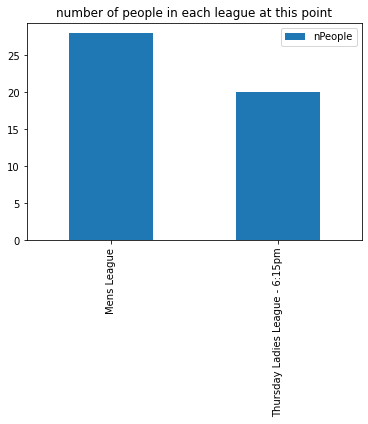

In [888]:
#do some plotting...visually see how people distributed
gather = pd.DataFrame(np.nan, index = otherLeagues, columns=['nPeople'])
for name in otherLeagues:
    gather.loc[name,'nPeople'] = len(leagueDict_all[name])
    
gather.plot(kind = 'bar',title='number of people in each league at this point')
gather

,nPeople
Sunday 5:15pm Open,21.0
Monday 4pm Open,25.0
Monday Evening Open,32.0
Tuesday 10am Open,28.0
Wednesday 4pm Open,28.0
Thursday 4pm Open,24.0


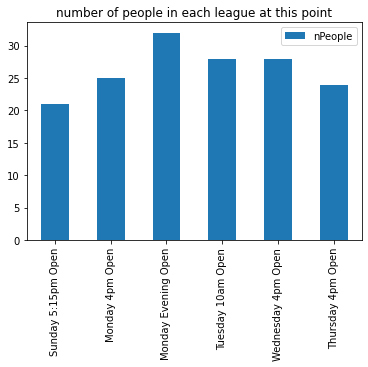

In [889]:
#do more plotting...visually see how people distributed
gather = pd.DataFrame(np.nan, index = openLeagues, columns=['nPeople'])
for name in openLeagues:
    gather.loc[name,'nPeople'] = len(leagueDict_open[name])
    
gather.plot(kind = 'bar',title='number of people in each league at this point')
gather

In [890]:
#gather up the number of people with # 'yes' < League_Number_Open
outcome = regTracking.copy(deep = True)

for idx, item in regTracking.iterrows():
    #if regTracking.loc[idx,'League_Number_Open'] != 'None':
    if np.isnan(regTracking.loc[idx,'League_Number_Open']) == False:
        r = regTracking.loc[idx,openLeagues]
        nLeagues = 0
        for item in range(0,len(r)):
            if r[item] == 'yes':
                nLeagues = nLeagues + 1
        if nLeagues == int(regTracking.loc[idx,'League_Number_Open']):
            #delete from the dataframe
            outcome.drop(idx,inplace = True)
    else: #did not want open leagues, drop them too
        outcome.drop(idx,inplace = True)
        
outcome.sort_values(by = 'League_Number_Open', inplace = True)

In [891]:
#this will be the list of people who did not get everything they wanted 
#(in terms of the # of 'championship' leagues)
len(outcome)

18

In [892]:
outcome

,index,First Name,Last Name,Email,League_Number_Open,Mens League,Thursday Ladies League - 6:15pm,Sunday 5:15pm Open,Monday 4pm Open,Monday Evening Open,Tuesday 10am Open,Wednesday 4pm Open,Thursday 4pm Open,randomNumCol
3,115,Haven,Todd Spencer,langner.miriam@gmail.com,1,No,No,NaN,NaN,NaN,no,no,NaN,3
8,34,Meghan,Lino,Cenataker84@gmail.com,1,No,done,NaN,NaN,NaN,no,NaN,NaN,8
10,9,Debra,Sawka,albertablu@gmail.com,1,No,No,NaN,NaN,NaN,no,NaN,NaN,10
150,166,eric,robillard,robill19@hotmail.com,2,No,No,NaN,yes,no,NaN,no,NaN,150
144,161,Pat,Kavanagh,Pkavanagh5@aol.com,2,No,No,yes,NaN,NaN,NaN,no,NaN,144
133,158,Peter,Jones,peter2tsol@gmail.com,2,No,No,NaN,NaN,yes,NaN,NaN,NaN,133
131,82,Jay,Flanders,jayflanders@comcast.net,2,done,No,NaN,NaN,no,NaN,yes,NaN,131
121,123,Mary,Kavanagh,m84pat@gmail.com,2,No,No,yes,NaN,NaN,NaN,no,NaN,121
116,77,Andy,Bailey,Hrdchrger9@aol.com,2,No,No,NaN,NaN,NaN,yes,no,NaN,116
110,117,Lauren,Kleinas,lauren@ljkgraphics.com,2,No,done,NaN,NaN,NaN,yes,NaN,NaN,110


In [893]:
#alphabetize regTracking before saving
regTracking.sort_values(by = 'Last Name',inplace = True)

outcome.to_csv(folder + '/exportOutcome.csv')
regTracking.to_csv(folder + '/exportTracking.csv')
regSorted.to_csv(folder + '/exportSorted.csv')
regInfo.to_csv(folder + '/exportInfo.csv')

In [894]:
#can run multiple times and see what the best possible outcome is...would want to keep that...

In [895]:
for problem in issueNames:
    print(problem, ': ', len(trackIssues[problem]), ' people in this category')

notInFirst :  0  people in this category
notInSecond :  1  people in this category
notInThird :  1  people in this category
notInFourth :  0  people in this category
notInFifth :  0  people in this category
noAdditionalChoice :  14  people in this category
